# A) FORECASTING


The goal of this project is to analyze the $production$ time series data and perform a forecasting model that provides reasonable forecasts at a 1-4 quarter horizon.

Here are the steps we will be following:

    1. Import and visualize the time series
    2. Build Holt Winter’s Exponential Smoothing Model
    3. Run model, make predictions and evaluate model accuracy

     


#### Importing libraries

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series

from sklearn.metrics import mean_squared_error
from math import sqrt

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose as sd

import warnings                                  
warnings.filterwarnings('ignore')

%matplotlib inline

## 1. Import and visualize the data

In [125]:
data_A = Series.from_csv('data_A.csv', header=0)#drop the header bc we know it is a time series with 1 set of values:production
print(data_A.head())

time
1956 Q1    284
1956 Q2    213
1956 Q3    227
1956 Q4    308
1957 Q1    262
Name: production, dtype: int64


In [126]:
print(data_A.describe()) 

count    218.000000
mean     415.371560
std       85.880662
min      213.000000
25%      379.250000
50%      422.000000
75%      465.750000
max      599.000000
Name: production, dtype: float64


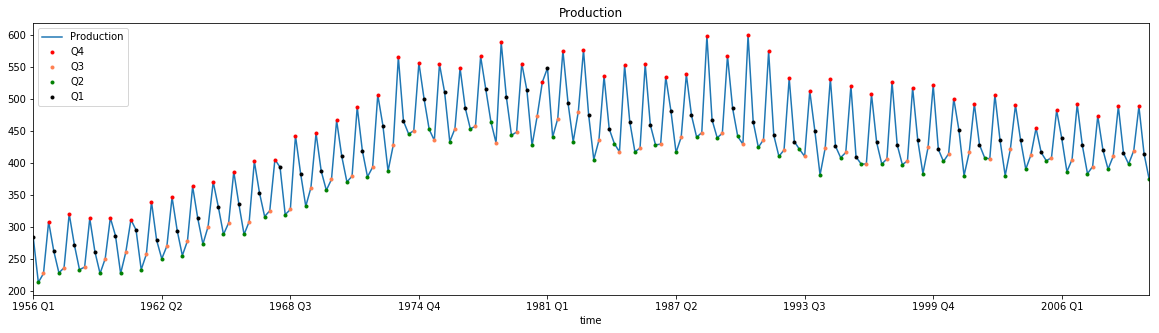

In [128]:
plt.rcParams['figure.figsize'] = [20, 5]

data_A.plot()
plt.xticks(rotation='vertical')

Q1=data_A[0::4]
Q2=data_A[1::4]
Q3=data_A[2::4]
Q4=data_A[3::4]

pd.concat([data_A,Q4],axis=1).ix[:,1].plot(style='.',color='red')
pd.concat([data_A,Q3],axis=1).ix[:,1].plot(style='.',color='coral')
pd.concat([data_A,Q2],axis=1).ix[:,1].plot(style='.',color='green')
pd.concat([data_A,Q1],axis=1).ix[:,1].plot(style='.',color='black')

plt.legend(["Production","Q4","Q3","Q2","Q1"])
plt.title("Production")

plt.show()

- Data exhibits trends: clear upward trend from 1956 to 1973 followed by a slight downward trend.
- Clear quarterly seasonality with a high in the 4th quarter and a low in the 2nd quarter.

Another tool to visualize the data is to use seasonal decomposition. With this, the trend and seasonality become even more obvious. We will use the Seasonal_decompose function from the Statsmodels package to extract the trend, seasonality and residual(noise) with a frequency of 4 since the season seems to be 4 quarters.

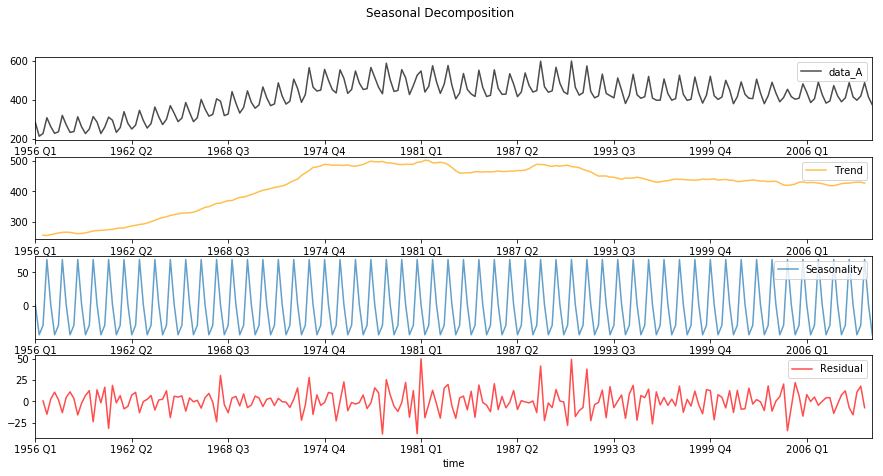

In [129]:
sd_data_A = sd(data_A, freq=4)

plt.figure(figsize=(15,7))
plt.suptitle("Seasonal Decomposition")

ax0=plt.subplot(411)
data_A.plot(label='data_A', alpha=0.7,color="black")
plt.legend()
ax1=plt.subplot(412)
sd_data_A.trend.plot(label='Trend', alpha=0.7,color="orange")
plt.legend()
ax2=plt.subplot(413)
sd_data_A.seasonal.plot(label='Seasonality', alpha=0.7)
plt.legend()
ax3=plt.subplot(414)
sd_data_A.resid.plot(label='Residual', alpha=0.7,color="red")
plt.legend()

plt.show()

Before applying a time series model, it is important to check its stationarity. A time series is stationary if all its statistical properties (mean,variance) remain constant over time. Initial plot of the data shows clear trends and seasonality but we will still check stationarity. 

We will plot the moving average and moving standard deviation curves. We can also perform a _Dickey-fuller test_ where the null hypothesis is that the time series is non- stationary. The result from the test will contain the test statistic and critical values for different confidence levels. If the test statistic is less than the critical values, we can reject the null hypothesis and say that this Time series is  stationary.

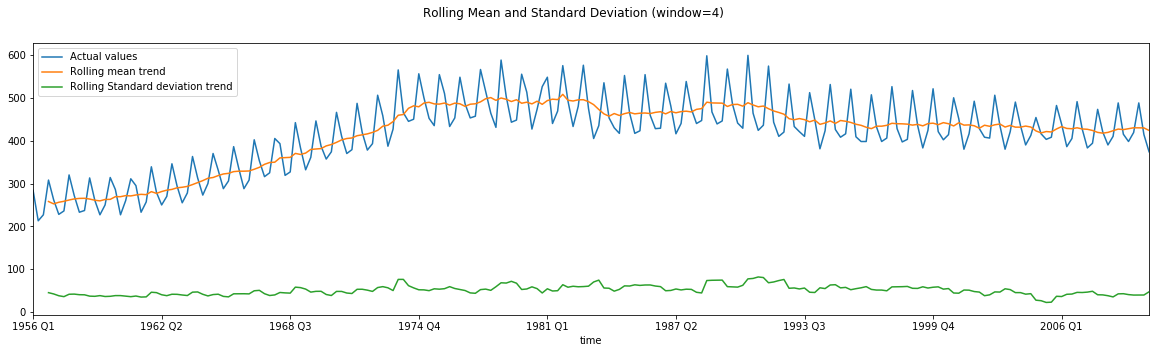

Results of Dickey-Fuller Test: 
Test Statistic                  -2.611338
p-value                          0.090677
#Lags Used                      14.000000
Number of Observations Used    203.000000
Critical Value (1%)             -3.462980
Critical Value (5%)             -2.875885
Critical Value (10%)            -2.574416
dtype: float64


In [130]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(data,wdw):
    #build Rolling mean
    rolling_mean = data.rolling(window=wdw).mean()
    #build Rolling Standard deviation
    rolling_sd= data.rolling(window=wdw).std()
    #Plot 2 rolling curves
    plt.figure(figsize=(20,7))
    pd.concat([data,rolling_mean,rolling_sd],axis=1).plot()

    plt.suptitle("Rolling Mean and Standard Deviation (window={})".format(wdw))
    plt.legend(["Actual values","Rolling mean trend","Rolling Standard deviation trend"],loc="upper left")
    plt.show()

    #Perform Dickey-Fuller test and print result:
    print ('Results of Dickey-Fuller Test: ')
    dftest = adfuller(data.values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

check_stationarity(data_A,4)


The plot shows the mean is not constant even though the std is small. We can easily say the time series is not stationary. 

After experimenting with a few moving average and standard deviation plots, and attempting to stationarize the time series in order to build an ARIMA model, I came to the conclusion that given the nature of the series (clearly not stationary and shows trends and obvious seasonality), the best approach to forecasting is the Holt Winter’s Exponential Smoothing method.

The __Holt Winter’s Exponential Smoothing (HWES)__ also called the __Triple Exponential Smoothing__ method models the next time step as an exponentially weighted linear function of observations at prior time steps, taking trend and seasonality into account.

## 2. Build Holt Winter’s Exponential Smoothing

The idea behind triple exponential smoothing is to apply exponential smoothing to the _seasonal component_, as well as _the level_ and _trend_. 

The model predicts a current or future value by computing the combined effects of these three influences. The model requires several parameters: one for each smoothing (ɑ, β, γ), the length of a season, and the number of periods in a season. I am adding a trend damping parameter (φ) so that the model can damp the trend as the forecast horizon increases.

We will run the model with the following parameters:
* __alpha__ is the smoothing factor for the level 
* __beta__ is the smoothing factor for the trend 
* __phi__ is the trend damping parameter
* __gamma__ is the smoothing factor for the seasonal component



In [137]:
def holt_winters(data,slen,extra_periods=0,alpha=0.4, beta=0.4, phi=0.9,gamma=0.3):
     
    """
    This function calculates a forecast with an exponential smoothing + damped trend method.
     
    Inputs
      - data: the original values
      - slen:season length
      - extra_periods:
      - alpha: the level parameter
      - beta: the trend parameter
      - phi: the trend damping parameter
      - gamma: the seasonality parameter 
    
    Outputs
    - Predictions
    - Mean Absolute Error
    - Plot of results
    - Extra period predictions
    """   
       
    #########################################################
    # Determine first seasonal estimation
    def init_season(data,slen):
        s = np.array([])
        data = np.array(data)
        for i in range(slen):
            # - Calculate columns that correspond to this season
            col = [x for x in range(len(data)) if x%slen==i]
                 
            # - Calculate season average 
            s = np.append(s,np.mean(data[col]))
         
        # - Normalize all season parameters (sum of parameters = slen)
        s /= np.mean(s)
        return s.tolist()
     
    # Initialize seasonal factors
    s = init_season(data,slen)
    
    #########################################################
    # Define/initialize f: forecast, a:level & b:trend
    f = [np.nan]
    a = [data[0]/s[0]]
    b = [(data[1]/s[1])-(data[0]/s[0])]
     
    #########################################################
    # Create the forecast for the first season
    for t in range(1,slen):
        # Update forecast based on last level (a) and trend (b)
        f.append((a[-1]+b[-1]*phi)*s[t])
         
        # Update the level based on the new data point
        a.append(alpha*data[t]/s[t]+(1-alpha)*(a[-1]+phi*b[-1]))
         
        # Update the trend based on the new data point
        b.append(beta*(a[-1]-a[-2])+(1-beta)*b[-1]*phi) 
     
    
    #########################################################
    # Create the forecast after the first season
    for t in range(slen,len(data)):
        # Update forecast based on last level (a) and trend (b)
        f.append((a[-1]+b[-1]*phi)*s[-slen])
         
        # Update the level based on the new data point
        a.append(alpha*data[t]/s[-slen]+(1-alpha)*(a[-1]+phi*b[-1]))
         
        # Update the trend based on the new data point
        b.append(beta*(a[-1]-a[-2])+(1-beta)*b[-1]*phi)
         
        # Update season
        s.append(gamma*data[t]/a[-1] + (1-gamma)*s[-slen])
    
    #########################################################
    #for future periods
    for t in range(extra_periods):
        # Update the forecast as the most up-to-date level + trend
        f.append((a[-1]+b[-1]*phi)*s[-slen])
        # the level equals the forecast
        a.append(f[-1]/s[-slen])
        # Update the trend as the previous trend
        b.append(b[-1]*phi)
        # Update the seasonality as the same seasonality factor last season
        s.append(s[-slen])
        # add next row with the right index and fill in ts by np.nan for easy plotting
        [year,q] =data[-1:].index.str.split(" ")[0]
        
        if (q == "Q1"):
            data=data.append(pd.Series({"0":np.nan},index=[str(year)+" Q2"]))
        elif (q == "Q2"):
            data=data.append(pd.Series({"0":np.nan},index=[str(year)+" Q3"]))
        elif (q == "Q3"):
            data=data.append(pd.Series({"0":np.nan},index=[str(year)+" Q4"]))
        elif (q == "Q4"):
            data=data.append(pd.Series({"0":np.nan},index=[str(int(year)+1)+" Q1"]))
        
           
    #########################################################
    # Populate table with all the results
    dic = {"original":data,"forecast":f,"level":a,"trend":b,"season":s}
    results = pd.DataFrame.from_dict(dic)[["original","forecast","level","trend","season"]]
    results.index.name = "time"
    
    #########################################################
    # Compute and return Mean Absolute error percentage 
    def mean_absolute_percentage_error(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    maep=mean_absolute_percentage_error(results["original"], results["forecast"])
    maep=round(maep,2)
    
    print("Holt Winters with alpha={}, beta={}, phi={},gamma={} yields a Mean Absolute error percentage of :{}%".format(alpha,beta,phi,gamma,maep))

    #########################################################
    #plot results
    pd.concat([train,test,results["forecast"]],axis=1).plot(figsize=(15,7))
    plt.legend(["train","test","forecast"])
    plt.title("Holt Winters forecasting")
    plt.show()
    
    #########################################################
    #Return prediction
    if extra_periods>0:
        print("Predicted production for the next {} quarters: ".format(extra_periods))
        print(results["forecast"][-extra_periods:])


def split_dataset(data,p=0.67):
    X = data.values
    train_size = int(len(X) * p)
    train, test = data[0:train_size], data[train_size-1:len(X)]
    return train,test



## 3. Run model 

Holt Winters with alpha=0.4, beta=0.4, phi=0.9,gamma=0.3 yields a Mean Absolute error percentage of :2.83%


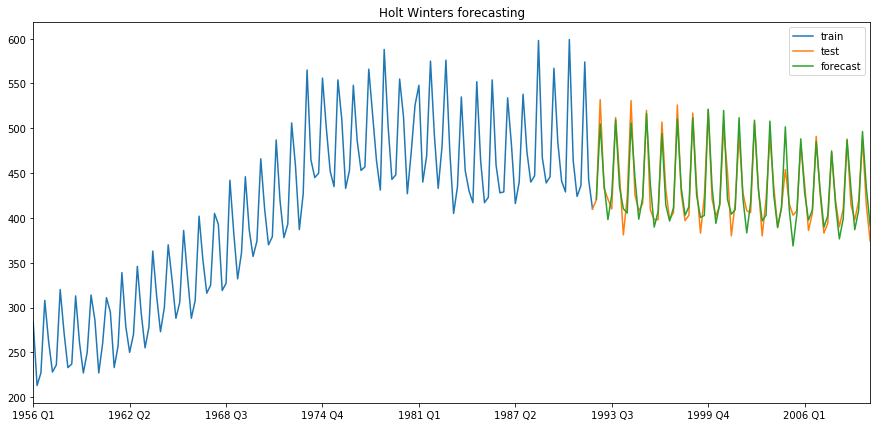

In [141]:
train,test=split_dataset(data_A)
holt_winters(test,4,extra_periods=0)

Judging by the plot and the MAE percentage, our model was able to successfully approximate the initial time series, capturing the quarterly seasonality, overall trend, and even some anomalies. Now let's run the model to predict production for the next 4 quarters.

Holt Winters with alpha=0.4, beta=0.4, phi=0.9,gamma=0.3 yields a Mean Absolute error percentage of :2.83%


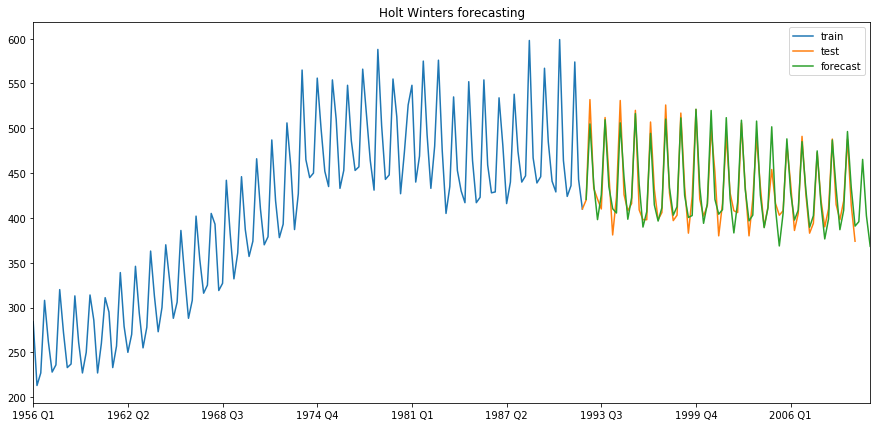

Predicted production for the next 4 quarters: 
time
2010 Q3    395.802693
2010 Q4    465.282916
2011 Q1    402.488489
2011 Q2    368.312519
Name: forecast, dtype: float64


In [142]:
holt_winters(test,4,extra_periods=4)